# Surface Albedo

This notebook demonstrates several aspects of PSM3 (ground) surface albedo:

- Albedo is determined on a daily basis (UTC).
- Snow-free albedo values are the same every year.
- Snowy albedo values seem slightly inconsistent with the model that supposedly generates them.

In [1]:
import pvlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Keweenaw Peninsula, Michigan
pvlib.iotools.psm3.PSM_URL = "https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-2-2-download.csv"
dfs = []
for year in [2018, 2019, 2020, 2021]:
    df, meta = pvlib.iotools.get_psm3(47.42, -88.05, 'DEMO_KEY', 'assessingsolar@gmail.com',
                                      names=year, interval=5,
                                      attributes=['air_temperature', 'surface_albedo', 'ghi'],
                                      map_variables=False, leap_day=True)
    dfs.append(df)

In [3]:
df = pd.concat(dfs)
df = df.tz_convert('UTC')
# undo end of year "roll-over" effect:
df.index = [
    dt.replace(year=dt.year-1)
    if dt.year == dt.tz_convert('Etc/GMT+5').year + 1
    else dt
    for dt in df.index
]
df = df.sort_index()

## 24-hour interval

PSM3 albedo values are constant within each day, only updating at midnight UTC.
The following plot demonstrates this behavior:

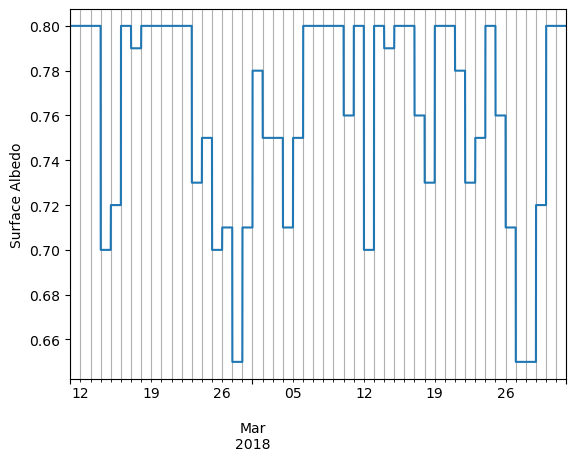

In [4]:
df.loc['2018-02-11':'2018-03-31', 'Surface Albedo'].plot()
plt.ylabel('Surface Albedo')
plt.grid(which='both', axis='x')

## Snow-free albedo is the same every year

Snow-free albedo varies somewhat day to day, but each year is the same (considering only non-snowy times), with the caveat that the post-February portion of leap years are shifted by one day relative to normal years (i.e., "same albedo every year" is in relation to the day of year (Julian date), not the typical month-day calendar date).

NSRDB publications claim that PSM3 surface albedo values are derived from MODIS data (specifically, the MCD43GF data product) <cite data-cite="maclaurin2016albedo"></cite> <cite data-cite="sengupta2019evolution"></cite>.  Given the fact that these MODIS datasets are available for each calendar year, it's not clear why there is no variation in the PSM3's snow-free albedo values. 

In any case, let's demonstrate these effects.  First, that post-February leap year data is shifted by one day relative to other years:

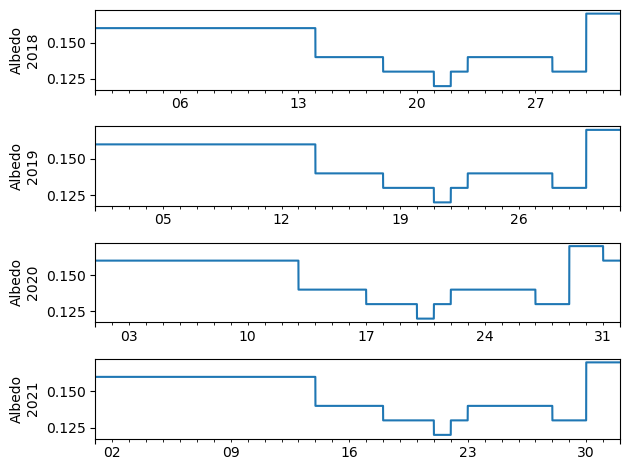

In [5]:
fig, axes = plt.subplots(4, 1, sharex=False)
for ax, year in zip(axes, [2018, 2019, 2020, 2021]):
    this_year = df.loc[f'{year}-08', 'Surface Albedo']
    this_year.plot(ax=ax)
    ax.set_ylabel(f'Albedo\n{year}')
    ax.set_xticklabels([])

fig.tight_layout()

And now, that there is no year-to-year variation in snow-free albedo (when aligning years based on Julian date):

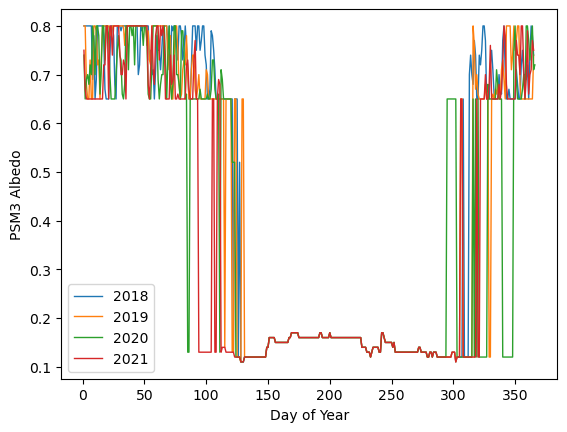

In [6]:
fig, ax = plt.subplots()
for year in [2018, 2019, 2020, 2021]:
    this_year = df.loc[str(year), 'Surface Albedo']
    ax.plot(this_year.index.dayofyear, this_year.values, label=year, lw=1)

ax.set_xlabel('Day of Year')
ax.set_ylabel('PSM3 Albedo')
ax.legend();

## Snowy albedo

Albedo corresponding to snow cover is calculated differently from snow-free albedo.  Snow cover data comes from the IMS dataset <cite data-cite="maclaurin2016albedo"></cite> <cite data-cite="sengupta2019evolution"></cite>.  PSM Version 3.2.2 includes a new model for calculating these snowy albedo values.  Previously, snowy times were set to a fixed albedo of 0.86.  Now, albedo varies with temperature according to a piecewise linear function that decreases snow albedo as ambient temperature approaches 0 °C <cite data-cite="sengupta2022recent"></cite> <cite data-cite="sengupta2022webinar"></cite>.  This piecewise linear model is described in [Ross & Walsh, 1987](https://doi.org/10.1029/jc092ic12p13115).

It is possible to recreate the PSM3 albedo values based on daily average ambient temperature, with the exception of an apparent shift of roughly 0.7 °C.  The cause of this shift is unknown.

First, let's demonstrate the existence of the shift between PSM3 albedo and the albedo from the Ross & Walsh model:

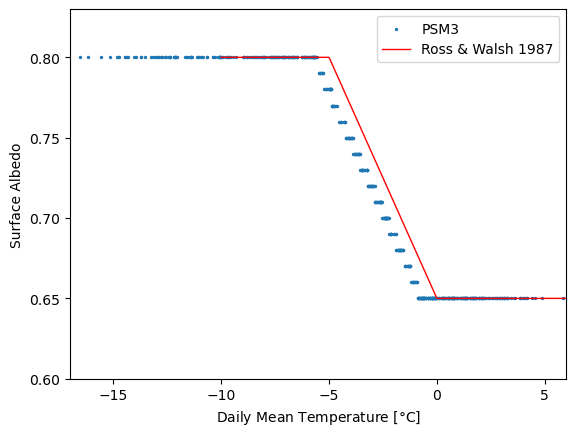

In [7]:
daily_albedo = df['Surface Albedo'].resample('d').mean()

# This averaging method was found via experimentation:
daily_temperature = df['Temperature'].iloc[::12].resample('d').mean()

plt.scatter(daily_temperature, daily_albedo, s=2, label='PSM3')

x = np.linspace(-10, 20, 1000)
rw87 = np.clip(0.65 - 0.03 * x, 0.65, 0.8)
plt.plot(x, rw87, label='Ross & Walsh 1987', c='r', lw=1)

plt.legend()
plt.xlim(-17, 6)
plt.ylim(0.6, 0.83)
plt.xlabel('Daily Mean Temperature [$\degree$C]')
plt.ylabel('Surface Albedo');

Now, let's determine the value of the shift and show that the PSM3 values are otherwise consistent with the Ross & Walsh model to within the precision of the PSM3 values (two decimal places):

In [8]:
from scipy.optimize import minimize_scalar

# simple way to select just the snowy subset:
filt = daily_albedo > 0.6

def objective(offset):
    rw87 = np.clip(0.65 - 0.03*(daily_temperature+offset), 0.65, 0.8)
    err = (rw87[filt] - daily_albedo[filt]).abs().mean()
    return err

result = minimize_scalar(objective, bracket=[0, 1])
offset = result.x
offset

0.7166666746908338

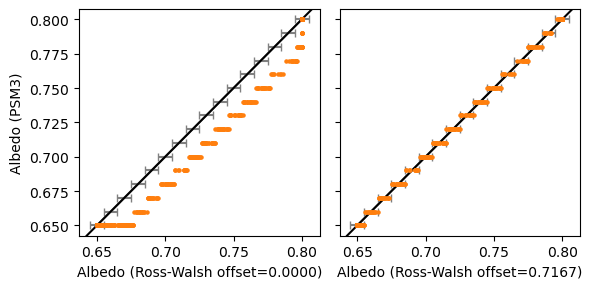

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 3))

for offset, ax in zip([0, offset], axes):
    rw87 = np.clip(0.65 - 0.03*(daily_temperature+offset), 0.65, 0.8)
    ax.scatter(rw87[filt], daily_albedo[filt], s=5, c='tab:orange')
    ax.axline((0.7, 0.7), slope=1, c='k', zorder=0)
    # PSM3 albedo is rounded to two decimal places, so show ±0.005 error bars
    x = np.arange(0.65, 0.80, 0.01)
    ax.errorbar(x, x, xerr=0.005, capsize=3, c='grey', zorder=-1)
    ax.set_xlabel(f'Albedo (Ross-Walsh {offset=:0.04f})')

axes[0].set_ylabel('Albedo (PSM3)')
fig.tight_layout()

In [10]:
%load_ext watermark
%watermark --iversions -u -d -t

Last updated: 2023-02-07 20:57:52

matplotlib: 3.5.2
pvlib     : 0.9.3
pandas    : 1.5.0
numpy     : 1.22.3

